In [1]:
# Basic scientific python imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook 
# Spikeinterface imports (could do this cleaner, oh well)
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.preprocessing as spre
import spikeinterface.exporters as sxp
import spikeinterface.widgets as sw
import spikeinterface.full as si
import probeinterface as pi
import spikeinterface.curation as scur

# import spikeinterface_gui
# Core python imports
import os
import time
from pathlib import Path
from IPython.display import Audio

In [2]:
## If reading series of intan recordings
rec_name = 'poke1_230520_153135'
path_to_folder = Path('C:/Users/lwood39/Documents/VNCMP/2023-05-20/' + rec_name)
dircontents = os.listdir(path_to_folder)
file_names = [x for x in dircontents if '.rhd' in x]
recording_list = []
for file in file_names:
    path_to_file = os.path.join(path_to_folder, file)
    recording_list.append(se.IntanRecordingExtractor(path_to_file, stream_id='0'))
recording = si.concatenate_recordings(recording_list)
display(recording)

# Uncomment to grab just a section of a recording
# recording = recording.frame_slice(start_frame=0, end_frame=int(231*30000))

## If reading open ephys recording session
# path_to_folder = Path('G:/SponbergLab/Data/Leo_2023-03-29_15-03-40/Record Node 103/experiment1')
# # path_to_folder = Path('G:/VNCMP/20230308/2023-03-08_13-08-30/Record Node 104')
# recording = se.read_openephys(path_to_folder, block_index=0, stream_id='0')
# recording = si.SelectSegmentRecording(recording, 0)

C:\Users\lwood39\spikeinterface\src\spikeinterface\core\baserecording.py:218: RuntimeWarning: overflow encountered in long_scalars
  memory_bytes = num_samples * num_channels * dtype_size_bytes


ConcatenateSegmentRecording: 32 channels - 30.0kHz - 1 segments - 36,792,064 samples 
                             1,226.40s (20.44 minutes) - uint16 dtype - -1940275200.00 B

In [4]:
# Remove analog input channels if present, not needed for spike sorting
if any('ADC' in s for s in recording.get_channel_ids()):  
    recording = recording.remove_channels([x for x in recording.get_channel_ids() if 'ADC' in x])
recording.get_channel_ids()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U64')

<IPython.core.display.Javascript object>


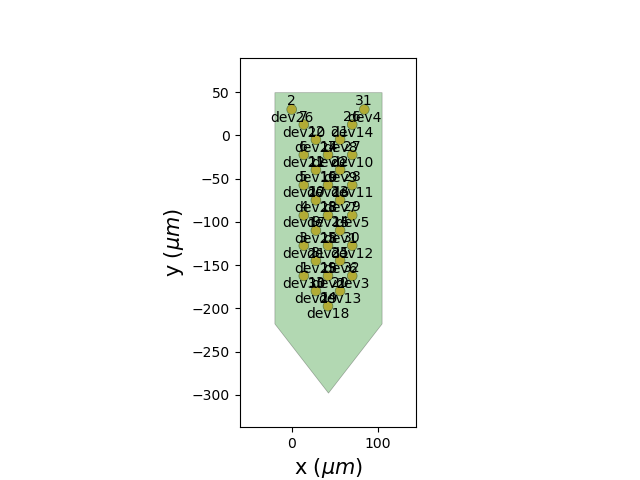

Probe - 32ch - 1shanks

In [5]:
probe = pi.read_probeinterface('A32_A1x32-Poly5-6mm-35s-100.json')
pi.plotting.plot_probe_group(probe, with_channel_index=True, with_device_index=True)
# recording.set_probegroup(probe)
recording.set_probe(probe.probes[0], in_place=True)
recording.get_probe()

In [8]:
# Save a cache of filtered data and cache of raw data
recording_cache_filter = si.bandpass_filter(recording, freq_min=350, freq_max=5000).save(format='binary', n_jobs=8, chunk_duration='10s')
recording_cache_raw = recording.save(format='binary', n_jobs=8, chunk_duration='10s')

Use cache_folder=C:\Users\lwood39\AppData\Local\Temp\spikeinterface_cache\tmplb4bpwkw\L95DXI7F
write_binary_recording with n_jobs = 8 and chunk_size = 300000


write_binary_recording:   0%|          | 0/123 [00:00<?, ?it/s]

Use cache_folder=C:\Users\lwood39\AppData\Local\Temp\spikeinterface_cache\tmpk5iuvwso\L2AR9MUX
write_binary_recording with n_jobs = 8 and chunk_size = 300000


write_binary_recording:   0%|          | 0/123 [00:00<?, ?it/s]

## Run Sorter

In [9]:
si.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'klusta',
 'mountainsort4',
 'mountainsort5',
 'pykilosort',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

In [10]:
sorter = 'mountainsort5'
print(ss.get_default_sorter_params(sorter))
ss.get_sorter_params_description(sorter)

{'scheme': '2', 'detect_threshold': 5.5, 'detect_sign': -1, 'detect_time_radius_msec': 0.5, 'snippet_T1': 20, 'snippet_T2': 20, 'npca_per_channel': 3, 'npca_per_subdivision': 10, 'snippet_mask_radius': 250, 'scheme1_detect_channel_radius': 150, 'scheme2_phase1_detect_channel_radius': 200, 'scheme2_detect_channel_radius': 50, 'scheme2_max_num_snippets_per_training_batch': 200, 'scheme2_training_duration_sec': 300, 'scheme2_training_recording_sampling_mode': 'uniform', 'scheme3_block_duration_sec': 1800, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True}


{'scheme': "Which sorting scheme to use: '1, '2', or '3'",
 'detect_threshold': 'Detection threshold - recommend to use the default',
 'detect_sign': 'Use -1 for detecting negative peaks, 1 for positive, 0 for both',
 'detect_time_radius_msec': 'Determines the minimum allowable time interval between detected spikes in the same spatial region',
 'snippet_T1': 'Number of samples before the peak to include in the snippet',
 'snippet_T2': 'Number of samples after the peak to include in the snippet',
 'npca_per_channel': 'Number of PCA features per channel in the initial dimension reduction step',
 'npca_per_subdivision': 'Number of PCA features to compute at each stage of clustering in the isosplit6 subdivision method',
 'snippet_mask_radius': 'Radius of the mask to apply to the extracted snippets',
 'scheme1_detect_channel_radius': 'Channel radius for excluding events that are too close in time in scheme 1',
 'scheme2_phase1_detect_channel_radius': 'Channel radius for excluding events tha

In [14]:
params = ss.get_default_sorter_params(sorter)
params['scheme'] = '2'
params['detect_sign'] = 1
params['detect_threshold'] = 5.5
params['freq_min'] = 350
params['freq_max'] = 7000
params['npca_per_subdivision'] = 15
params['scheme2_phase1_detect_channel_radius'] = 50
params['scheme2_training_duration_sec'] = 800
params['scheme2_max_num_snippets_per_training_batch'] = 10000
params['scheme3_block_duration_sec'] = 500
   
tic = time.perf_counter()
sort = ss.run_sorter(
    sorter,
    recording=recording_cache_raw,
    output_folder=sorter,
#     docker_image="spikeinterface/" + sorter + "-compiled-base:latest", #<- use for kilosort
    verbose=False,
    **params)
print(f'{time.perf_counter()-tic} seconds elapsed')
Audio('notification-sound.wav', autoplay=True)

print(sort)

Number of channels: 32
Number of timepoints: 24000000
Sampling frequency: 30000.0 Hz
Channel 0: [ 42.  -22.5]
Channel 1: [  56. -110.]
Channel 2: [  42.  -162.5]
Channel 3: [  70.  -162.5]
Channel 4: [84. 30.]
Channel 5: [ 70.  -92.5]
Channel 6: [  56. -145.]
Channel 7: [ 56. -75.]
Channel 8: [56. -5.]
Channel 9: [ 56. -40.]
Channel 10: [ 70.  -22.5]
Channel 11: [ 70.  -57.5]
Channel 12: [  70.  -127.5]
Channel 13: [  56. -180.]
Channel 14: [70.  12.5]
Channel 15: [ 42.  -92.5]
Channel 16: [ 42.  -57.5]
Channel 17: [ 14.  -92.5]
Channel 18: [  42.  -197.5]
Channel 19: [ 28. -40.]
Channel 20: [14.  12.5]
Channel 21: [  14.  -127.5]
Channel 22: [ 14.  -22.5]
Channel 23: [ 28. -75.]
Channel 24: [28. -5.]
Channel 25: [  28. -145.]
Channel 26: [ 0. 30.]
Channel 27: [ 14.  -57.5]
Channel 28: [  28. -110.]
Channel 29: [  28. -180.]
Channel 30: [  14.  -162.5]
Channel 31: [  42.  -127.5]
Loading traces
Detecting spikes

Adjacency for detect spikes with channel radius 50
[[0, 8, 9, 10, 11, 14, 

Extracting and classifying snippets
Removing duplicates
Time chunk 5 of 12
Loading traces
Detecting spikes

Adjacency for detect spikes with channel radius 50
[[0, 8, 9, 10, 11, 14, 16, 19, 20, 22, 24, 27], [1, 5, 6, 7, 12, 15, 17, 21, 23, 25, 28, 31], [2, 3, 6, 12, 13, 18, 21, 25, 29, 30, 31], [2, 3, 6, 12, 13, 18, 25, 29, 31], [4, 8, 14], [1, 5, 7, 11, 12, 15, 16, 23, 28, 31], [1, 2, 3, 6, 12, 13, 21, 25, 28, 29, 30, 31], [1, 5, 7, 9, 11, 15, 16, 17, 19, 23, 27, 28], [0, 4, 8, 9, 10, 14, 19, 20, 22, 24], [0, 7, 8, 9, 10, 11, 16, 19, 22, 23, 24, 27], [0, 8, 9, 10, 11, 14, 16, 19, 24], [0, 5, 7, 9, 10, 11, 15, 16, 19, 23], [1, 2, 3, 5, 6, 12, 15, 25, 28, 31], [2, 3, 6, 13, 18, 25, 29, 30], [0, 4, 8, 10, 14, 24], [1, 5, 7, 11, 12, 15, 16, 17, 21, 23, 27, 28, 31], [0, 5, 7, 9, 10, 11, 15, 16, 17, 19, 22, 23, 27], [1, 7, 15, 16, 17, 21, 23, 27, 28, 31], [2, 3, 13, 18, 29, 30], [0, 7, 8, 9, 10, 11, 16, 19, 22, 23, 24, 27], [0, 8, 20, 22, 24, 26], [1, 2, 6, 15, 17, 21, 25, 28, 30, 31], [0, 

Extracting and classifying snippets
Removing duplicates
Time chunk 11 of 12
Loading traces
Detecting spikes

Adjacency for detect spikes with channel radius 50
[[0, 8, 9, 10, 11, 14, 16, 19, 20, 22, 24, 27], [1, 5, 6, 7, 12, 15, 17, 21, 23, 25, 28, 31], [2, 3, 6, 12, 13, 18, 21, 25, 29, 30, 31], [2, 3, 6, 12, 13, 18, 25, 29, 31], [4, 8, 14], [1, 5, 7, 11, 12, 15, 16, 23, 28, 31], [1, 2, 3, 6, 12, 13, 21, 25, 28, 29, 30, 31], [1, 5, 7, 9, 11, 15, 16, 17, 19, 23, 27, 28], [0, 4, 8, 9, 10, 14, 19, 20, 22, 24], [0, 7, 8, 9, 10, 11, 16, 19, 22, 23, 24, 27], [0, 8, 9, 10, 11, 14, 16, 19, 24], [0, 5, 7, 9, 10, 11, 15, 16, 19, 23], [1, 2, 3, 5, 6, 12, 15, 25, 28, 31], [2, 3, 6, 13, 18, 25, 29, 30], [0, 4, 8, 10, 14, 24], [1, 5, 7, 11, 12, 15, 16, 17, 21, 23, 27, 28, 31], [0, 5, 7, 9, 10, 11, 15, 16, 17, 19, 22, 23, 27], [1, 7, 15, 16, 17, 21, 23, 27, 28, 31], [2, 3, 13, 18, 29, 30], [0, 7, 8, 9, 10, 11, 16, 19, 22, 23, 24, 27], [0, 8, 20, 22, 24, 26], [1, 2, 6, 15, 17, 21, 25, 28, 30, 31], [0,

In [15]:
job_kwargs = dict(n_jobs=8, chunk_duration="1s", progress_bar=True)

# wave_extract = si.extract_waveforms(
#     recording_cache_justfilter, 
#     sort, 
#     './waveforms',
#     ms_before=2., ms_after=2.,
#     max_spikes_per_unit=100000,
#     overwrite=True, 
#     **job_kwargs)
# # Find redundant units, perform extraction again with those removed
# sort_no_redundant = scur.remove_redundant_units(wave_extract, align=True)
wave_extract = si.extract_waveforms(
    recording_cache_justfilter, 
#     sort_no_redundant,
    sort,
    './waveforms',
    ms_before=2., ms_after=2.,
    max_spikes_per_unit=100000,
    overwrite=True, 
    **job_kwargs)

extract waveforms memmap:   0%|          | 0/1227 [00:00<?, ?it/s]

## Phy GUI

In [16]:
phy_save_path = './phy_folder/' + sorter + '_' + rec_name
sxp.export_to_phy(wave_extract, 
                  phy_save_path, 
                  remove_if_exists=True,
                  **job_kwargs)

# save record of params
with open(phy_save_path+'/params_log.txt', 'w') as f: 
    for key, value in params.items(): 
        f.write('%s:%s\n' % (key, value))
        
        

write_binary_recording with n_jobs = 8 and chunk_size = 30000


write_binary_recording:   0%|          | 0/1227 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/1227 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/43 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/43 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/1227 [00:00<?, ?it/s]

Run:
phy template-gui  C:\Users\lwood39\Documents\AutoSpikeSort\phy_folder\mountainsort5_poke1_230520_153135\params.py


 To run Phy, use cmd or Powershell, and do one of the following:
 
 1. Run the command spit out by the cell above, often something like:
 
 ```phy template-gui  C:\Users\lwood39\Documents\AutoSpikeSort\phy_folder\mountainsort5_poke1_230520_153135\params.py```
 
 
 2. Navigate to phy_folder created by the above cell, then run phy command
 
 Example:
 
 ```cd C:/Users/lwood39/Documents/AutoSpikeSort/phy_folder_kilosort```
 
 ```phy template-gui params.py```
 

## WHY IS IT CRASHING? Some general notes

I've noticed a few common patterns that will lead to crashes. Here are some notes on those, in no particular order.

- **Kilosort is crashing. Stack trace has something related to a gpuArray error, and/or mentions something like a nan**

  This almost always seems to be one of the batches of kilosort containing no detected spikes. Kilosort runs on independent "batches", sections of your data of a certain length. If one of those has no spikes, it seems to typically create a nan value that gums up the works. The easy solution is to either (a) Only feed in data that has spiking of some kind throughout, or (b) increase the batch size, with the 'NT' parameter

<IPython.core.display.Javascript object>


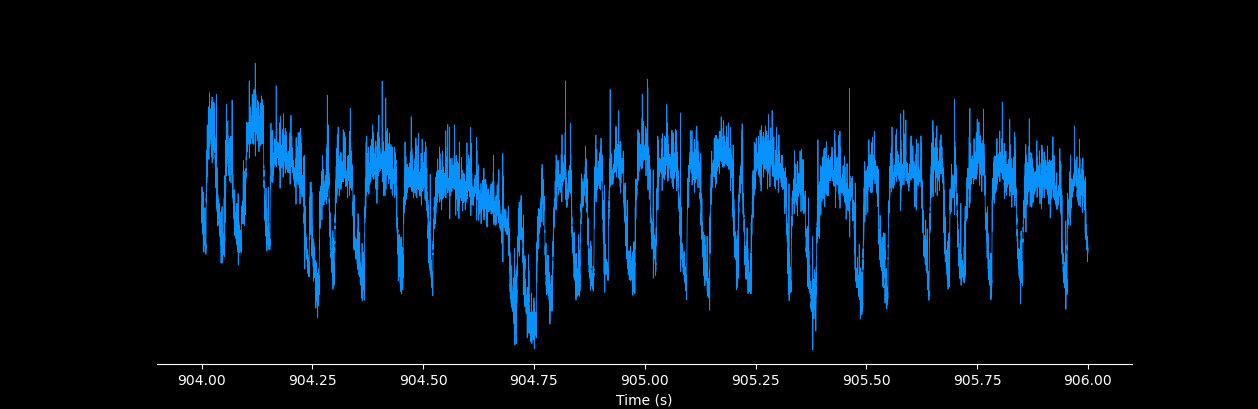

In [61]:
fs = 30000
times = (904, 906)
data = recording_cache_raw.get_traces(
    start_frame=int(times[0]*fs), end_frame=int(times[1]*fs),
    return_scaled=True, channel_ids=['3'])
data_filt = recording_cache_justfilter.get_traces(
    start_frame=int(times[0]*fs), end_frame=int(times[1]*fs),
    return_scaled=True, channel_ids=['3'])
time = np.arange(times[0], times[1], 1/fs)

plt.style.use("dark_background")
plt.figure()
plt.plot(time, data, '#0991FC', lw=0.6)
# plt.plot(time, data_filt, '#FF0201', alpha=0.9, lw=0.6)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.xlabel('Time (s)')
plt.show()

<IPython.core.display.Javascript object>


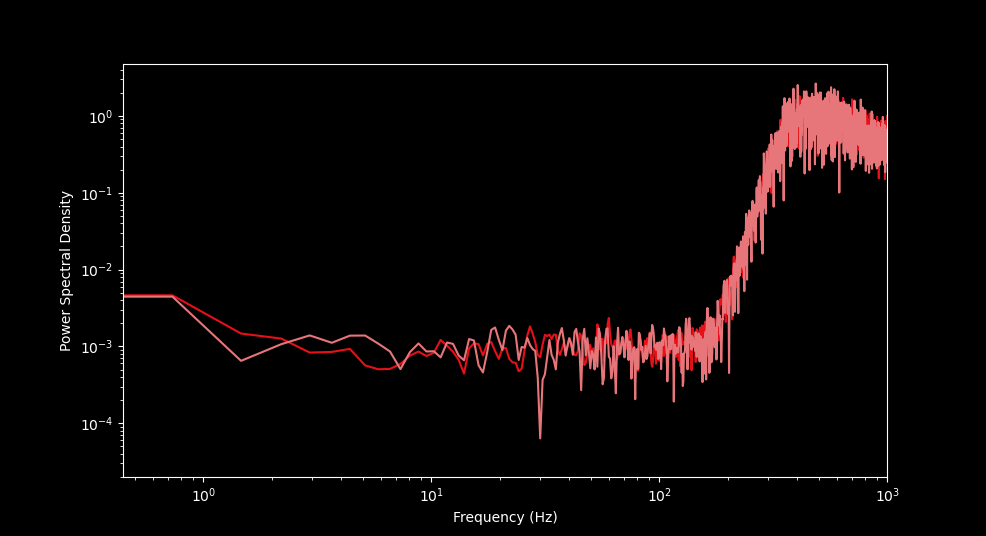

C:\Users\lwood39\AppData\Local\Temp\ipykernel_97356\462182528.py:24: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim((0, 1000))


In [58]:
from scipy import signal

times = (900, 903.2)
data = recording_cache_justfilter.get_traces(
    start_frame=int(times[0]*fs), end_frame=int(times[1]*fs), 
    return_scaled=True, channel_ids=['0'])

plt.figure()
f, Pxx_spec = signal.welch(data.flatten(), fs, 
                           nperseg=4096*10, 
                           scaling='density',
                           detrend=False)
plt.loglog(f, np.sqrt(Pxx_spec), '#E61019')

times = (903.6, 906)
data_flap = recording_cache_justfilter.get_traces(
    start_frame=int(times[0]*fs), end_frame=int(times[1]*fs), 
    return_scaled=True, channel_ids=['0'])
f, Pxx_spec = signal.welch(data_flap.flatten(), fs, 
                           nperseg=4096*10, 
                           scaling='density',
                           detrend=False)
plt.loglog(f, np.sqrt(Pxx_spec), '#E6767A')
plt.xlim((0, 1000))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.show()

## Spikeinterface GUI

In [ ]:
import spikeinterface_gui
os.chdir(Path('C:/Users/lwood39/Documents/AutoSpikeSort/'))
app = spikeinterface_gui.mkQApp()
win = spikeinterface_gui.MainWindow(wave_extract)
win.show()
app.exec()

You have 100000 in your WaveformExtractor, the display can be slow
You should re run the WaveformExtractor with max_spikes_per_unit=500
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)


C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\pyqtgraph\GraphicsScene\GraphicsScene.py:325: RuntimeWarning: Error sending drag event:
Traceback (most recent call last):
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
    self.io_loop.start()
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
    self.asyncio_loop.run_forever(

slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None

## Plot sandbox

<IPython.core.display.Javascript object>


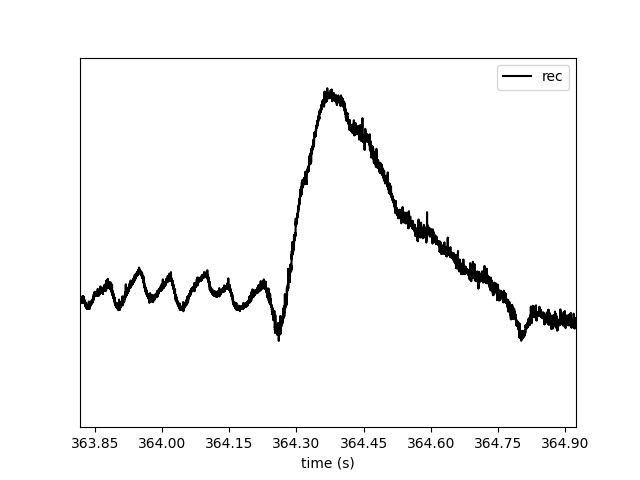

In [45]:
sw.plot_timeseries(recording_cache_raw, time_range=(300, 420), channel_ids=['0'], return_scaled=True)
plt.show()

<IPython.core.display.Javascript object>


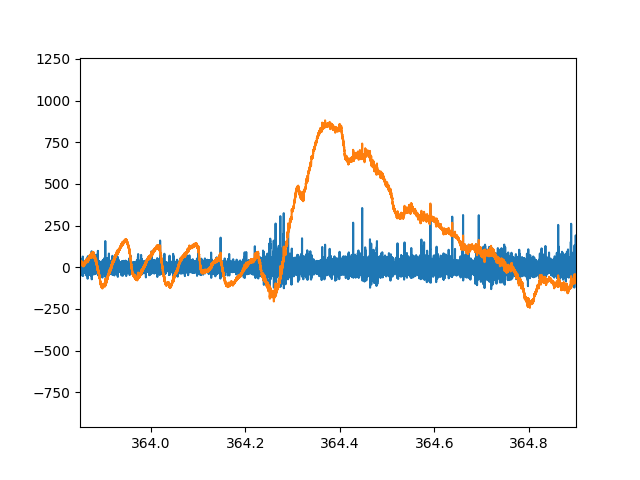

In [56]:
times = (300, 400)
data = recording_cache_justfilter.get_traces(start_frame=int(times[0]*fs), 
                                      end_frame=int(times[1]*fs), 
                                      return_scaled=True, 
                                      channel_ids=['3'])
rawdata = recording_cache_raw.get_traces(start_frame=int(times[0]*fs), 
                                      end_frame=int(times[1]*fs), 
                                      return_scaled=True, 
                                      channel_ids=['3'])
time = np.arange(times[0], times[1], 1/fs)
plt.figure()
plt.plot(time, data)
plt.xlim((363.85, 364.9))
# plt.show()

# plt.figure()
plt.plot(time, rawdata/5)
plt.xlim((363.85, 364.9))
plt.show()